In [1]:
2+2

4

# Feedback

## Load Modules

In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print("file_dir: -> ",file_dir)

parent_dir = file_dir.parent
print(parent_dir)

sys.path.append(str(parent_dir))

file_dir: ->  C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [3]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import (
    clean_up_categoricals
    )

from pa_lib.vis import (
    boxplot_histogram,
    )

from pa_lib.file import (
    project_dir,
    load_bin,
    load_csv,
    load_xlsx
    )
from pa_lib.util import (
    cap_words
    )                 
import os,fnmatch

https://stackabuse.com/python-list-files-in-a-directory/

# Load Data (Feedback)

In [12]:
def load_feedback(sales_folder):
    sales_subfolder = os.listdir(sales_folder)
    pattern = "EK_LIST*.xlsx"

    container_df = pd.DataFrame()
    columns_in_xlsx = [
        "Gepard-Nr. Endkunde",
        "Endkunde",
        "Chance",
        "Feedback - bitte auswählen",
        "falls nicht hilfreich, bitte hier einen kurzen Kommentar angeben - entweder pro Zeile oder für die Gesamt-Liste",
    ]
    rename_columns = ["Endkunde_NR", "Endkunde", "Prob_1", "Feedback", "Kommentar"]

    for kw_folder in sales_subfolder:

        if kw_folder >= "2019_07_15":  # Begin of automatisation

            all_files_list = os.listdir(sales_folder / kw_folder)

            for file in all_files_list:

                if fnmatch.fnmatch(file, pattern):
                    # print(f"{kw_folder}  ---- {file}") # Check!
                    vkber_df = load_xlsx(sales_folder / kw_folder / file).loc[
                        :, columns_in_xlsx
                    ]  # .iloc[:,[0,1,-3,-2,-1]])

                    vkber_df.columns = rename_columns

                    vkber_df.loc[:, "folder"] = kw_folder
                    vkber_df.loc[:, "file_name"] = file

                    container_df = container_df.append(vkber_df, ignore_index=False)

    container_df.loc[:, "Kuerzel"] = container_df.loc[:, "file_name"].apply(
        lambda x: x[19:22]
    )

    # Remove all redundant rows:
    feedback_exists = (
        (  # Feedback or Kommentar exists
            ~container_df.loc[:, "Feedback"].isna()
            | ~container_df.loc[:, "Kommentar"].isna()
        )
        & ~container_df.loc[:, "Endkunde_NR"].isna()  # Endkunde_NR must exist
    )

    return container_df.loc[feedback_exists, :].sort_values(
        ["folder", "file_name"], ascending=[False, True]
    )

In [13]:
sales_folder = Path('P:\Service\Kennzahlen\Verkauf\PredictiveAnalytics')
print(sales_folder)

P:\Service\Kennzahlen\Verkauf\PredictiveAnalytics


In [14]:
%%capture
raw_feedback = load_feedback(sales_folder=sales_folder)

# Feedback Count

In [15]:
print(f"shape: {raw_feedback.shape}")

shape: (840, 8)


In [16]:
min(raw_feedback.shape[0], 3000)

840

In [17]:
import pandas as pd
pd.set_option('display.max_rows', min(raw_feedback.shape[0]+1 ,3000))
pd.set_option("display.max_colwidth",500)

In [18]:
raw_feedback.sample(5)

,Endkunde_NR,Endkunde,Prob_1,Feedback,Kommentar,folder,file_name,Kuerzel
16,575909,Música Romântica,11.253713,NaN,noch pendent,2019_11_18,EK_LIST_2W_KOMPAKT_RON.xlsx,RON
8,153269,Leukerbad Tourismus,25.246005,NaN,hat bei uns diverse Jahresflächen und AYMO,2019_11_18,EK_LIST_2W_KOMPAKT_RON.xlsx,RON
7,543341,Verein internationale Schneesportevents,12.000000,hilfreich,Termin abgemacht am 18.11. Events kommen je nach schneeverh.,2019_10_07,EK_LIST_2W_KOMPAKT_BON.xlsx,BON
2,615070,alpinavera,44.477667,hilfreich,Già contattato per promozione,2019_11_18,EK_LIST_2W_KOMPAKT_LPA.xlsx,LPA
19,643551,Ospedale Regionale di Locarno La Carità,2.400000,NaN,Già nella lista precedente,2019_10_07,EK_LIST_2W_KOMPAKT_LPA.xlsx,LPA


# Teilnahme

In [19]:
(
raw_feedback
    .groupby("folder")
    .agg({"Endkunde_NR": "count"})
    
)

,Endkunde_NR
folder,
2019_07_15,106
2019_09_23,111
2019_10_07,120
2019_10_21,106
2019_11_04,141
2019_11_18,160
2019_12_02,96


Text(0, 0.5, 'Anzahl')

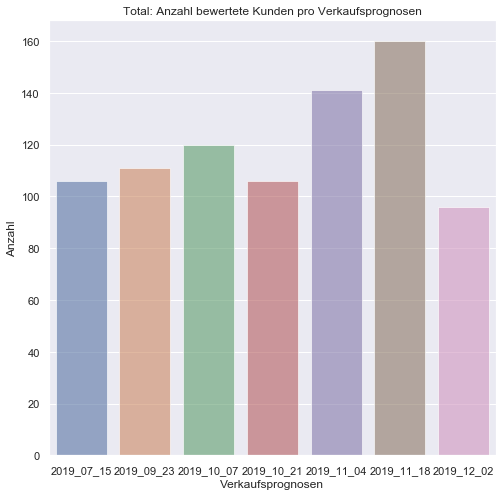

In [20]:
sns.set(style="darkgrid")
plt.figure(figsize=(8,8))
ax = (
    sns.countplot(
        x     = "folder",
        #y    = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        #order = raw_feedback.loc[:,'Kuerzel'].value_counts().index
        )
    )

plt.title("Total: Anzahl bewertete Kunden pro Verkaufsprognosen")
plt.xlabel("Verkaufsprognosen")
plt.ylabel("Anzahl")

## Insights

***
>1. Die Teilnahme nimmt zu.
2. The Vkber-Lists in the following folders have not been touched (see also timestamps on each xlsx-file):
    * `2019_09_09`
    * `2019_08_26` 
    * `2019_08_12`
    * [`2019_07_29`](P:\Service\Kennzahlen\Verkauf\PredictiveAnalytics\2019_07_29)
***

## Top participants

In [21]:
(
raw_feedback
    .groupby("Kuerzel")
    .agg({"Endkunde": "count"})
    .sort_values("Endkunde",ascending=False)
)

,Endkunde
Kuerzel,
LPA,136
BON,100
TRA,77
CGA,69
JAN,59
SFA,42
ACO,39
MBU,38
ROK,37


Text(0, 0.5, 'Anzahl')

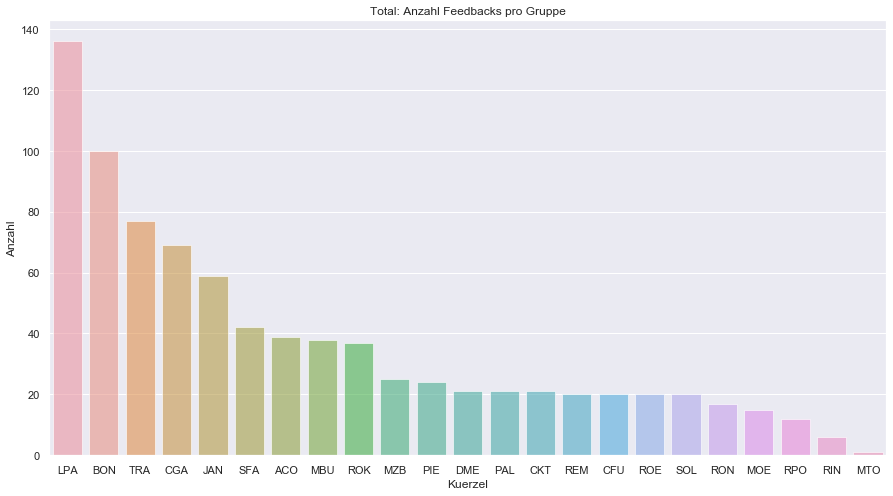

In [22]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
ax = (
    sns.countplot(
        x     = "Kuerzel",
        #y    = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        order = raw_feedback.loc[:,'Kuerzel'].value_counts().index
        )
    )
    
plt.title("Total: Anzahl Feedbacks pro Gruppe")
plt.xlabel("Kuerzel")
plt.ylabel("Anzahl")

Text(84.5, 0.5, 'Kuerzel')

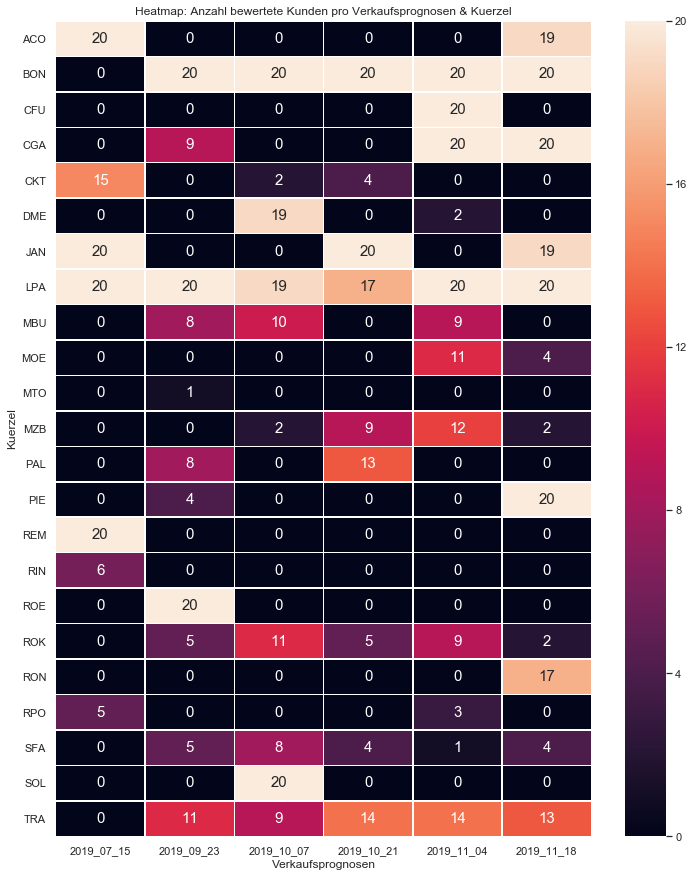

In [15]:
heatmap_data = pd.pivot_table(
    raw_feedback,
    index      = "folder",
    columns    = "Kuerzel",
    values     = "Endkunde_NR",
    aggfunc    = np.count_nonzero,
    fill_value = 0
    ).T

plt.figure(figsize=(12,15))

ax = sns.heatmap(
    data       = heatmap_data,
    linewidths = 0.5,
    annot      = True,
    annot_kws={"size": 15},
    )

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Heatmap: Anzahl bewertete Kunden pro Verkaufsprognosen & Kuerzel")
plt.xlabel("Verkaufsprognosen")
plt.ylabel("Kuerzel")

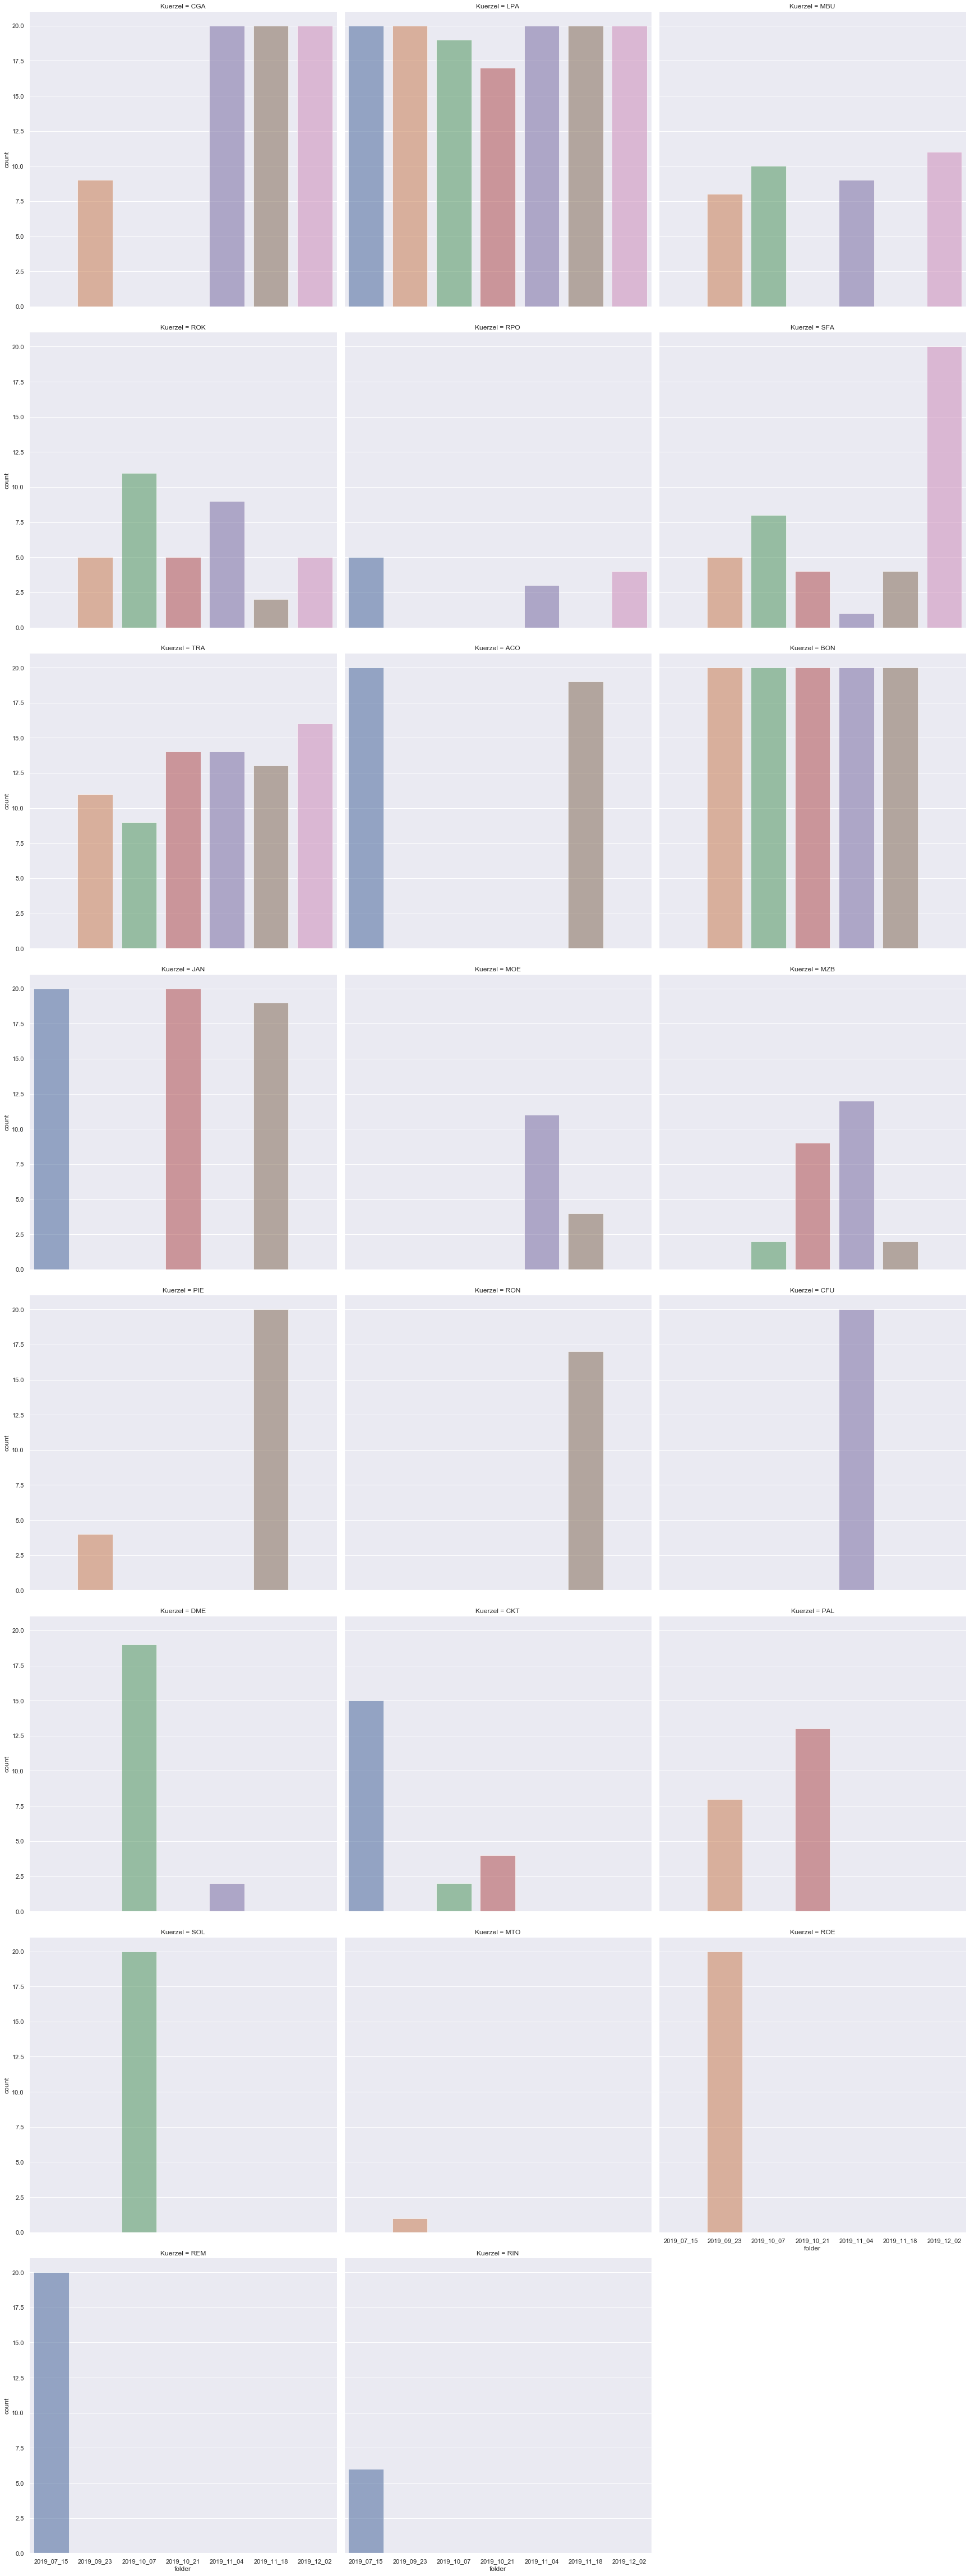

In [23]:
g = (
    sns.catplot(
        x="folder",
        #hue="folder",
        col="Kuerzel",
        data=raw_feedback,
        kind="count",
        height=8,
        aspect=1,
        col_wrap=3,
        alpha=0.6,
        )
    )

## Insights

***
>1. Vorsicht: Die Verkaufsberater erhalten jeweils eine unterschiedliche Anzahl Leads.
***

# Feedback so far: helpful? not helpful?

In [24]:
(
raw_feedback
    .groupby("Feedback")
    .agg({"Endkunde": "count"})
    .sort_values("Endkunde",ascending=False)
)

,Endkunde
Feedback,
hilfreich,302
nicht hilfreich,288
nicht bearbeitet,42


Text(0, 0.5, 'Anzahl')

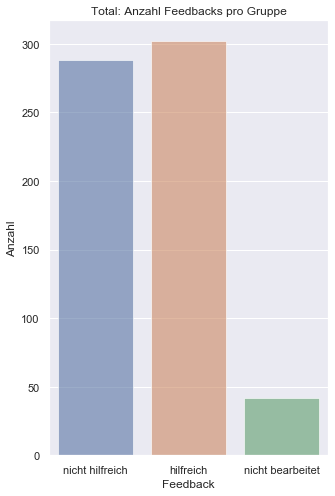

In [25]:
sns.set(style="darkgrid")
plt.figure(figsize=(5,8))
ax = (
    sns.countplot(
        x     = "Feedback",
        #y    = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        )
    )
    
plt.title("Total: Anzahl Feedbacks pro Gruppe")

plt.xlabel("Feedback")
plt.ylabel("Anzahl")

Text(0, 0.5, 'Anzahl')

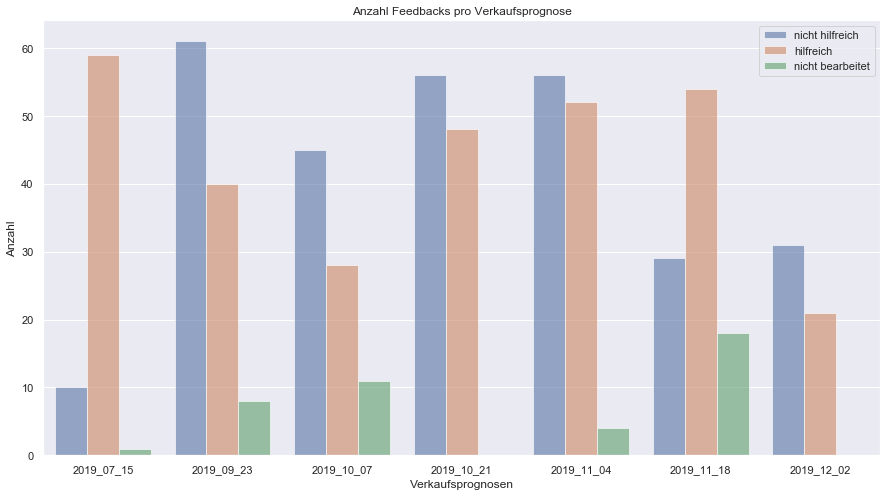

In [42]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
ax = (
    sns.countplot(
        x     = "folder",
        hue   = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        )
    )
plt.legend(loc='best')

plt.title("Anzahl Feedbacks pro Verkaufsprognose")
plt.xlabel("Verkaufsprognosen")
plt.ylabel("Anzahl")

## Insights

***
> 1. Seit der Umstellung auf Random Forest `2019_11_18` ist die  Anzahl der `hilfreich` grösser als `nicht hilfreich`
***

# `Kommentar` Felder

## `nicht hilfreich`, `nicht bearbeitet`, `NaN`

In [27]:
not_helpful_rows = (
    ~raw_feedback
        .Feedback
        .isin({"hilfreich"})
    )

interesting_cols = ["Endkunde_NR", "Endkunde", "Prob_1","Feedback","Kommentar", "folder", "Kuerzel"]

not_helpful_df = (
    raw_feedback
        .loc[not_helpful_rows,interesting_cols]
        .sort_values(["folder","Feedback"], ascending=[False,False])
    )

print(f"\nAnzahl Einträge: {not_helpful_df.shape[0]}\n")

display(not_helpful_df)


Anzahl Einträge: 538



,Endkunde_NR,Endkunde,Prob_1,Feedback,Kommentar,folder,Kuerzel
0,620921,Bakker Projekt Management SA,62.937983,nicht hilfreich,Già contattato per promozione Natalizia,2019_12_02,LPA
1,523059,Moda & Style SA,61.125227,nicht hilfreich,Gia in contatto FeF comunicazione,2019_12_02,LPA
2,611548,Start Lab Sagl,49.828932,nicht hilfreich,Gia visitato e informato su promozione Natalizia,2019_12_02,LPA
3,105183,Monn SA,39.717478,nicht hilfreich,Mandato e-mail per promozione non interessati,2019_12_02,LPA
4,628403,Swiss Helicopter SA,39.122302,nicht hilfreich,Interessati solo a campagne estive,2019_12_02,LPA
5,618630,Di Fabio Arredamenti SA,38.348553,nicht hilfreich,Visitato ca. 1 mese fa non interessato,2019_12_02,LPA
6,564582,Associazione Locatari,38.177456,nicht hilfreich,"Visitato poco temp fa, richiesto campagna Traffic",2019_12_02,LPA
9,586913,Abitare arredamenti interni SA,35.364100,nicht hilfreich,Gia contattato fatto campagna promozionale,2019_12_02,LPA
10,615070,alpinavera,34.571008,nicht hilfreich,Sempre in contatto,2019_12_02,LPA
11,617660,Parco Nocc SA,33.533187,nicht hilfreich,Gia contattati al momento non interessati,2019_12_02,LPA


## Insights

***
> 1. In den einzelnen Listen befinden sind politische Gruppierungen vorhanden. Nicht erwünscht.
2. Einige der Endkunden sind aufgelöst (zb. Insolvenz)
3. Einige Kunden buchen ausschliesslich über Agentur
4. Kunden sind eigentlich bei anderem Verkausberater
5. Einige Kunden haben für einmalige Events bei uns in der Vergangenheit gebucht. Keine Wiederholungen geplant (zb. Jubiläen)
***

## `hilfreich`

In [28]:
helpful_rows = ~not_helpful_rows

In [29]:
print(f"\nAnzahl Eintraege: {raw_feedback.loc[helpful_rows,interesting_cols].shape[0]}\n")

display(raw_feedback.loc[helpful_rows,interesting_cols])


Anzahl Eintraege: 302



,Endkunde_NR,Endkunde,Prob_1,Feedback,Kommentar,folder,Kuerzel
7,492894,Fondazione Bambini Cardiopatici nel Mondo,36.848045,hilfreich,NaN,2019_12_02,LPA
8,116473,Arti Parr SA,35.408435,hilfreich,NaN,2019_12_02,LPA
12,610334,Geantrade Sagl,33.258983,hilfreich,NaN,2019_12_02,LPA
13,621770,Banca Raiffeisen della Campagnadorna,32.907310,hilfreich,NaN,2019_12_02,LPA
3,570734,Offbeat Concert GmbH,48.794491,hilfreich,Termin - 03.12.2019,2019_12_02,RPO
19,117904,Emil Frey AG,35.775056,hilfreich,Termin - 20.12.2019,2019_12_02,RPO
10,134796,Meier Schreinerei AG,39.414231,hilfreich,Kontaktaufnahme,2019_12_02,SFA
14,611280,Benevol Thurgau,35.734771,hilfreich,Kontakaufnahme,2019_12_02,SFA
15,618641,Covin AG,35.233235,hilfreich,Kontaktaufnahme,2019_12_02,SFA
16,547372,Stedy Gwürz AG,35.227630,hilfreich,Kontaktaufnahme (wiederkehrend in der Liste),2019_12_02,SFA


## Insights

***
> 1. Obwohl vermerkt, dass Kunde kein Interesse hat, wird der Lead als `hilfreich` bewertet?
***